# VCF File Parser

A parser for Variant Call Format (VCF) files supporting both uncompressed (`.vcf`) and compressed (`.vcf.gz`) formats.

**Features:**
- Parses VCF v4.1/4.2/4.3 files
- Handles both `.vcf` and `.vcf.gz` (bgzip/gzip) compressed files
- Stores results in a pandas DataFrame (optimal for columnar variant data)
- Preserves metadata and header information
- Unit tested with generated sample data
- Performance benchmarked with visualizations

## 1. Imports and Setup

In [1]:
import gzip
import os
import time
import random
import unittest
import tempfile
import shutil
from dataclasses import dataclass, field
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 120, "font.size": 10})

## 2. VCF Parser Implementation

In [2]:
@dataclass
class VCFHeader:
    """Stores parsed VCF header information."""
    meta_lines: list = field(default_factory=list)      # raw ## lines
    info_fields: dict = field(default_factory=dict)      # INFO definitions
    format_fields: dict = field(default_factory=dict)    # FORMAT definitions
    filter_fields: dict = field(default_factory=dict)    # FILTER definitions
    contig_fields: dict = field(default_factory=dict)    # contig definitions
    sample_ids: list = field(default_factory=list)       # sample column names
    file_format: str = ""                                # VCF version string


class VCFParser:
    """Parser for VCF files (uncompressed and gzip-compressed).

    Results are stored in a pandas DataFrame – an optimal columnar
    data structure for variant data that supports fast filtering,
    grouping, and statistical operations.
    """

    MANDATORY_COLS = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]

    def __init__(self, filepath: str):
        self.filepath = filepath
        self.header = VCFHeader()
        self.variants: pd.DataFrame = pd.DataFrame()
        self._parse_time: float = 0.0

    # ---- public API --------------------------------------------------------

    def parse(self) -> pd.DataFrame:
        """Parse the VCF file and return a DataFrame of variant records."""
        start = time.perf_counter()
        opener = self._get_opener()
        header_lines = []
        data_lines = []

        with opener(self.filepath, "rt") as fh:
            for line in fh:
                line = line.rstrip("\n")
                if line.startswith("##"):
                    header_lines.append(line)
                elif line.startswith("#CHROM"):
                    header_lines.append(line)
                    self._parse_column_header(line)
                else:
                    if line:  # skip blank lines
                        data_lines.append(line)

        self._parse_meta(header_lines)
        self._build_dataframe(data_lines)
        self._parse_time = time.perf_counter() - start
        return self.variants

    def summary(self) -> dict:
        """Return summary statistics about the parsed VCF."""
        if self.variants.empty:
            return {}
        df = self.variants
        return {
            "total_variants": len(df),
            "chromosomes": sorted(df["CHROM"].unique().tolist()),
            "num_chromosomes": df["CHROM"].nunique(),
            "variant_types": self._classify_variants().value_counts().to_dict(),
            "filter_counts": df["FILTER"].value_counts().to_dict(),
            "mean_quality": float(df["QUAL"].mean()) if df["QUAL"].dtype != object else None,
            "num_samples": len(self.header.sample_ids),
            "parse_time_sec": round(self._parse_time, 4),
        }

    # ---- private helpers ---------------------------------------------------

    def _get_opener(self):
        """Return the appropriate file opener based on extension."""
        if self.filepath.endswith(".gz"):
            return gzip.open
        return open

    def _parse_column_header(self, line: str):
        """Parse the #CHROM header line to extract sample IDs."""
        cols = line.lstrip("#").split("\t")
        if len(cols) > 9:  # FORMAT + sample columns present
            self.header.sample_ids = cols[9:]

    def _parse_meta(self, header_lines: list):
        """Parse ## meta-information lines."""
        for line in header_lines:
            if not line.startswith("##"):
                continue
            self.header.meta_lines.append(line)
            key_value = line[2:]  # strip leading ##

            if key_value.startswith("fileformat="):
                self.header.file_format = key_value.split("=", 1)[1]
            elif key_value.startswith("INFO="):
                parsed = self._parse_structured_field(key_value[5:])
                if parsed and "ID" in parsed:
                    self.header.info_fields[parsed["ID"]] = parsed
            elif key_value.startswith("FORMAT="):
                parsed = self._parse_structured_field(key_value[7:])
                if parsed and "ID" in parsed:
                    self.header.format_fields[parsed["ID"]] = parsed
            elif key_value.startswith("FILTER="):
                parsed = self._parse_structured_field(key_value[7:])
                if parsed and "ID" in parsed:
                    self.header.filter_fields[parsed["ID"]] = parsed
            elif key_value.startswith("contig="):
                parsed = self._parse_structured_field(key_value[7:])
                if parsed and "ID" in parsed:
                    self.header.contig_fields[parsed["ID"]] = parsed

    @staticmethod
    def _parse_structured_field(raw: str) -> dict:
        """Parse a <key=value,...> structured header field."""
        raw = raw.strip()
        if raw.startswith("<") and raw.endswith(">"):
            raw = raw[1:-1]
        result = {}
        # Handle Description which may contain commas inside quotes
        parts = []
        buf = []
        in_quotes = False
        for ch in raw:
            if ch == '"':
                in_quotes = not in_quotes
                buf.append(ch)
            elif ch == ',' and not in_quotes:
                parts.append(''.join(buf))
                buf = []
            else:
                buf.append(ch)
        if buf:
            parts.append(''.join(buf))

        for part in parts:
            if '=' in part:
                k, v = part.split('=', 1)
                result[k.strip()] = v.strip().strip('"')
        return result

    def _build_dataframe(self, data_lines: list):
        """Convert raw data lines into a typed pandas DataFrame."""
        if not data_lines:
            self.variants = pd.DataFrame(columns=self.MANDATORY_COLS)
            return

        all_cols = self.MANDATORY_COLS.copy()
        has_format = len(self.header.sample_ids) > 0
        if has_format:
            all_cols.append("FORMAT")
            all_cols.extend(self.header.sample_ids)

        rows = [line.split("\t") for line in data_lines]
        df = pd.DataFrame(rows)
        # Assign column names for however many columns we actually got
        df.columns = all_cols[: len(df.columns)]

        # Type conversions
        df["POS"] = pd.to_numeric(df["POS"], errors="coerce").astype("Int64")
        df["QUAL"] = pd.to_numeric(df["QUAL"].replace(".", np.nan), errors="coerce")
        df["CHROM"] = df["CHROM"].astype("category")
        df["FILTER"] = df["FILTER"].astype("category")

        self.variants = df

    def _classify_variants(self) -> pd.Series:
        """Classify each variant as SNP, INS, DEL, or MNV."""
        def classify(row):
            ref, alt = row["REF"], str(row["ALT"]).split(",")[0]
            if len(ref) == 1 and len(alt) == 1:
                return "SNP"
            elif len(ref) > len(alt):
                return "DEL"
            elif len(ref) < len(alt):
                return "INS"
            else:
                return "MNV"
        return self.variants.apply(classify, axis=1)

## 3. Sample VCF File Generation

In [3]:
def generate_sample_vcf(filepath: str, num_variants: int = 200,
                        num_samples: int = 3, compressed: bool = False,
                        seed: int = 42):
    """Generate a synthetic VCF file for testing."""
    rng = random.Random(seed)
    bases = "ACGT"
    chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    sample_names = [f"SAMPLE_{i+1}" for i in range(num_samples)]
    filters = ["PASS", "PASS", "PASS", "PASS", "LowQual", "LowDP"]

    lines = []
    # -- meta-information
    lines.append("##fileformat=VCFv4.2")
    lines.append('##INFO=<ID=DP,Number=1,Type=Integer,Description="Total read depth">')
    lines.append('##INFO=<ID=AF,Number=A,Type=Float,Description="Allele frequency">')
    lines.append('##INFO=<ID=MQ,Number=1,Type=Float,Description="Mapping quality">')
    lines.append('##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">')
    lines.append('##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Sample read depth">')
    lines.append('##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype quality">')
    lines.append('##FILTER=<ID=LowQual,Description="Low quality variant">')
    lines.append('##FILTER=<ID=LowDP,Description="Low depth variant">')
    for c in chroms:
        lines.append(f'##contig=<ID={c},length={rng.randint(50_000_000, 250_000_000)}>')

    # -- column header
    cols = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
    cols.extend(sample_names)
    lines.append("\t".join(cols))

    # -- variant records
    genotypes = ["0/0", "0/1", "1/1", "0/0", "0/1"]
    for i in range(num_variants):
        chrom = rng.choice(chroms)
        pos = rng.randint(1, 200_000_000)
        vid = f"rs{rng.randint(100000, 9999999)}" if rng.random() > 0.3 else "."
        ref = rng.choice(bases)

        # create different variant types
        vtype = rng.random()
        if vtype < 0.65:  # SNP
            alt = rng.choice([b for b in bases if b != ref])
        elif vtype < 0.80:  # insertion
            alt = ref + ''.join(rng.choice(bases) for _ in range(rng.randint(1, 5)))
        elif vtype < 0.95:  # deletion
            ref = ref + ''.join(rng.choice(bases) for _ in range(rng.randint(1, 5)))
            alt = ref[0]
        else:  # multi-allelic SNP
            alts = rng.sample([b for b in bases if b != ref], 2)
            alt = ",".join(alts)

        qual = round(rng.uniform(5, 10000), 1)
        filt = rng.choice(filters)
        dp = rng.randint(5, 500)
        af = round(rng.uniform(0.01, 1.0), 4)
        mq = round(rng.uniform(20, 60), 1)
        info = f"DP={dp};AF={af};MQ={mq}"
        fmt = "GT:DP:GQ"

        sample_data = []
        for _ in sample_names:
            gt = rng.choice(genotypes)
            sdp = rng.randint(1, 200)
            gq = rng.randint(1, 99)
            sample_data.append(f"{gt}:{sdp}:{gq}")

        fields = [chrom, str(pos), vid, ref, alt, str(qual), filt, info, fmt]
        fields.extend(sample_data)
        lines.append("\t".join(fields))

    content = "\n".join(lines) + "\n"

    if compressed:
        with gzip.open(filepath, "wt") as f:
            f.write(content)
    else:
        with open(filepath, "w") as f:
            f.write(content)

    return filepath

In [4]:
# Generate sample files
os.makedirs("test_data", exist_ok=True)

sample_vcf = generate_sample_vcf("test_data/sample.vcf", num_variants=200)
sample_vcf_gz = generate_sample_vcf("test_data/sample.vcf.gz", num_variants=200, compressed=True)
large_vcf = generate_sample_vcf("test_data/large.vcf", num_variants=5000, seed=99)
empty_vcf = generate_sample_vcf("test_data/empty.vcf", num_variants=0)
single_vcf = generate_sample_vcf("test_data/single.vcf", num_variants=1)

print("Generated test files:")
for f in sorted(os.listdir("test_data")):
    size = os.path.getsize(os.path.join("test_data", f))
    print(f"  {f:25s}  {size:>8,} bytes")

Generated test files:
  empty.vcf                     1,471 bytes
  large.vcf                   525,915 bytes
  sample.vcf                   22,557 bytes
  sample.vcf.gz                 8,509 bytes
  single.vcf                    1,577 bytes


## 4. Quick Parse Demo

In [5]:
parser = VCFParser("test_data/sample.vcf")
df = parser.parse()

print("Parsed VCF summary:")
for k, v in parser.summary().items():
    print(f"  {k}: {v}")

print("\nFirst 5 variants:")
df.head()

Parsed VCF summary:
  total_variants: 200
  chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY']
  num_chromosomes: 24
  variant_types: {'SNP': 143, 'DEL': 33, 'INS': 24}
  filter_counts: {'PASS': 129, 'LowDP': 37, 'LowQual': 34}
  mean_quality: 4941.945
  num_samples: 3
  parse_time_sec: 0.0015

First 5 variants:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_1,SAMPLE_2,SAMPLE_3
0,chr18,53375075,rs9242600,T,G,2785.5,PASS,DP=393;AF=0.8078;MQ=47.9,GT:DP:GQ,1/1:72:20,0/1:196:44,0/0:24:49
1,chr4,96362793,rs4537923,A,AATAGG,5775.6,LowDP,DP=40;AF=0.0554;MQ=29.1,GT:DP:GQ,1/1:21:30,0/0:98:36,0/0:163:47
2,chr6,99369697,rs4579144,A,C,5343.7,PASS,DP=88;AF=0.4676;MQ=30.8,GT:DP:GQ,0/1:57:88,1/1:197:8,0/1:9:41
3,chr13,71871146,.,G,C,3959.3,LowDP,DP=239;AF=0.1514;MQ=25.6,GT:DP:GQ,0/1:138:34,0/1:110:75,0/0:93:29
4,chr5,136774923,rs890481,A,C,7921.8,PASS,DP=310;AF=0.0729;MQ=35.3,GT:DP:GQ,0/0:136:33,0/1:3:88,0/0:175:69


In [6]:
# Also parse compressed file
parser_gz = VCFParser("test_data/sample.vcf.gz")
df_gz = parser_gz.parse()

print(f"Compressed parse: {len(df_gz)} variants in {parser_gz._parse_time:.4f}s")
print(f"VCF version: {parser_gz.header.file_format}")
print(f"Samples: {parser_gz.header.sample_ids}")
print(f"INFO fields defined: {list(parser_gz.header.info_fields.keys())}")
print(f"FILTER fields defined: {list(parser_gz.header.filter_fields.keys())}")

Compressed parse: 200 variants in 0.0013s
VCF version: VCFv4.2
Samples: ['SAMPLE_1', 'SAMPLE_2', 'SAMPLE_3']
INFO fields defined: ['DP', 'AF', 'MQ']
FILTER fields defined: ['LowQual', 'LowDP']


## 5. Unit Tests

In [7]:
class TestVCFParser(unittest.TestCase):
    """Unit tests for VCFParser."""

    @classmethod
    def setUpClass(cls):
        cls.tmpdir = tempfile.mkdtemp()
        cls.vcf_path = os.path.join(cls.tmpdir, "test.vcf")
        cls.vcf_gz_path = os.path.join(cls.tmpdir, "test.vcf.gz")
        cls.empty_path = os.path.join(cls.tmpdir, "empty.vcf")
        generate_sample_vcf(cls.vcf_path, num_variants=100, seed=1)
        generate_sample_vcf(cls.vcf_gz_path, num_variants=100, seed=1, compressed=True)
        generate_sample_vcf(cls.empty_path, num_variants=0, seed=1)

    @classmethod
    def tearDownClass(cls):
        shutil.rmtree(cls.tmpdir)

    # -- Basic parsing tests -------------------------------------------------

    def test_parse_returns_dataframe(self):
        parser = VCFParser(self.vcf_path)
        result = parser.parse()
        self.assertIsInstance(result, pd.DataFrame)

    def test_correct_variant_count(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertEqual(len(parser.variants), 100)

    def test_mandatory_columns_present(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        for col in VCFParser.MANDATORY_COLS:
            self.assertIn(col, parser.variants.columns)

    def test_pos_is_numeric(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertTrue(pd.api.types.is_integer_dtype(parser.variants["POS"]))

    def test_qual_is_numeric(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertTrue(pd.api.types.is_float_dtype(parser.variants["QUAL"]))

    # -- Compressed file tests -----------------------------------------------

    def test_compressed_parse(self):
        parser = VCFParser(self.vcf_gz_path)
        parser.parse()
        self.assertEqual(len(parser.variants), 100)

    def test_compressed_matches_uncompressed(self):
        p1 = VCFParser(self.vcf_path)
        p1.parse()
        p2 = VCFParser(self.vcf_gz_path)
        p2.parse()
        pd.testing.assert_frame_equal(p1.variants, p2.variants)

    # -- Header tests --------------------------------------------------------

    def test_file_format_parsed(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertEqual(parser.header.file_format, "VCFv4.2")

    def test_info_fields_parsed(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertIn("DP", parser.header.info_fields)
        self.assertIn("AF", parser.header.info_fields)

    def test_sample_ids_parsed(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertEqual(len(parser.header.sample_ids), 3)
        self.assertEqual(parser.header.sample_ids[0], "SAMPLE_1")

    def test_filter_fields_parsed(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertIn("LowQual", parser.header.filter_fields)

    def test_contig_fields_parsed(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertGreater(len(parser.header.contig_fields), 0)

    # -- Edge case tests -----------------------------------------------------

    def test_empty_vcf(self):
        parser = VCFParser(self.empty_path)
        parser.parse()
        self.assertEqual(len(parser.variants), 0)
        self.assertIn("CHROM", parser.variants.columns)

    def test_summary_keys(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        s = parser.summary()
        expected_keys = ["total_variants", "chromosomes", "num_chromosomes",
                         "variant_types", "filter_counts", "mean_quality",
                         "num_samples", "parse_time_sec"]
        for key in expected_keys:
            self.assertIn(key, s)

    def test_summary_empty_vcf(self):
        parser = VCFParser(self.empty_path)
        parser.parse()
        self.assertEqual(parser.summary(), {})

    def test_chrom_is_categorical(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertTrue(pd.api.types.is_categorical_dtype(parser.variants["CHROM"]))

    def test_parse_time_recorded(self):
        parser = VCFParser(self.vcf_path)
        parser.parse()
        self.assertGreater(parser._parse_time, 0)


# Run tests inside the notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestVCFParser)
runner = unittest.TextTestRunner(verbosity=2)
result = runner.run(suite)

print(f"\n{'='*60}")
print(f"Tests run: {result.testsRun}")
print(f"Failures: {len(result.failures)}")
print(f"Errors: {len(result.errors)}")

test_chrom_is_categorical (__main__.TestVCFParser.test_chrom_is_categorical) ... 

/var/folders/4y/2qktr65n7jv79nxdt3hnf7wr0000gn/T/ipykernel_2903/1998639321.py:115: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  self.assertTrue(pd.api.types.is_categorical_dtype(parser.variants["CHROM"]))
ok


test_compressed_matches_uncompressed (__main__.TestVCFParser.test_compressed_matches_uncompressed) ... 

ok


test_compressed_parse (__main__.TestVCFParser.test_compressed_parse) ... 

ok


test_contig_fields_parsed (__main__.TestVCFParser.test_contig_fields_parsed) ... 

ok


test_correct_variant_count (__main__.TestVCFParser.test_correct_variant_count) ... 

ok


test_empty_vcf (__main__.TestVCFParser.test_empty_vcf) ... 

ok


test_file_format_parsed (__main__.TestVCFParser.test_file_format_parsed) ... 

ok


test_filter_fields_parsed (__main__.TestVCFParser.test_filter_fields_parsed) ... 

ok


test_info_fields_parsed (__main__.TestVCFParser.test_info_fields_parsed) ... 

ok


test_mandatory_columns_present (__main__.TestVCFParser.test_mandatory_columns_present) ... 

ok


test_parse_returns_dataframe (__main__.TestVCFParser.test_parse_returns_dataframe) ... 

ok


test_parse_time_recorded (__main__.TestVCFParser.test_parse_time_recorded) ... 

ok


test_pos_is_numeric (__main__.TestVCFParser.test_pos_is_numeric) ... 

ok


test_qual_is_numeric (__main__.TestVCFParser.test_qual_is_numeric) ... 

ok


test_sample_ids_parsed (__main__.TestVCFParser.test_sample_ids_parsed) ... 

ok


test_summary_empty_vcf (__main__.TestVCFParser.test_summary_empty_vcf) ... 

ok


test_summary_keys (__main__.TestVCFParser.test_summary_keys) ... 

ok


----------------------------------------------------------------------
Ran 17 tests in 0.025s

OK



Tests run: 17
Failures: 0
Errors: 0


## 6. Visualizations

### 6.1 — Performance Benchmark: Parse Time vs File Size

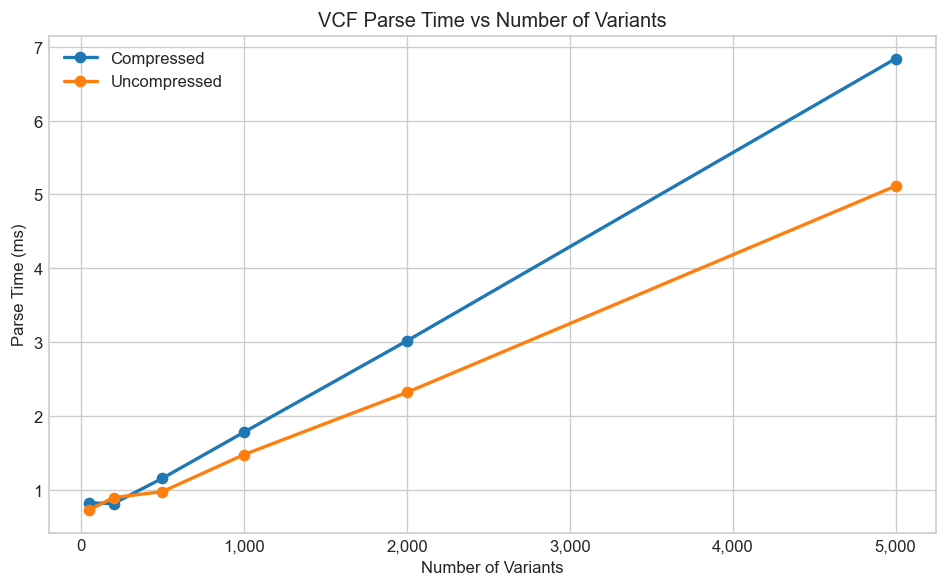

In [8]:
# Benchmark parsing across different file sizes
benchmark_sizes = [50, 200, 500, 1000, 2000, 5000]
bench_dir = tempfile.mkdtemp()
results = {"format": [], "num_variants": [], "parse_time": [], "file_size_kb": []}

for n in benchmark_sizes:
    for fmt, ext, comp in [("Uncompressed", ".vcf", False), ("Compressed", ".vcf.gz", True)]:
        path = os.path.join(bench_dir, f"bench_{n}{ext}")
        generate_sample_vcf(path, num_variants=n, compressed=comp, seed=42)
        fsize = os.path.getsize(path) / 1024

        times = []
        for _ in range(3):  # 3 runs for stable timing
            p = VCFParser(path)
            p.parse()
            times.append(p._parse_time)

        results["format"].append(fmt)
        results["num_variants"].append(n)
        results["parse_time"].append(np.median(times))
        results["file_size_kb"].append(fsize)

shutil.rmtree(bench_dir)
bench_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 5))
for fmt, grp in bench_df.groupby("format"):
    ax.plot(grp["num_variants"], grp["parse_time"] * 1000,
            marker="o", linewidth=2, label=fmt)
ax.set_xlabel("Number of Variants")
ax.set_ylabel("Parse Time (ms)")
ax.set_title("VCF Parse Time vs Number of Variants")
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.savefig("test_data/benchmark_parse_time.png", dpi=150)
plt.show()

### 6.2 — Compression Ratio: Uncompressed vs Compressed File Sizes

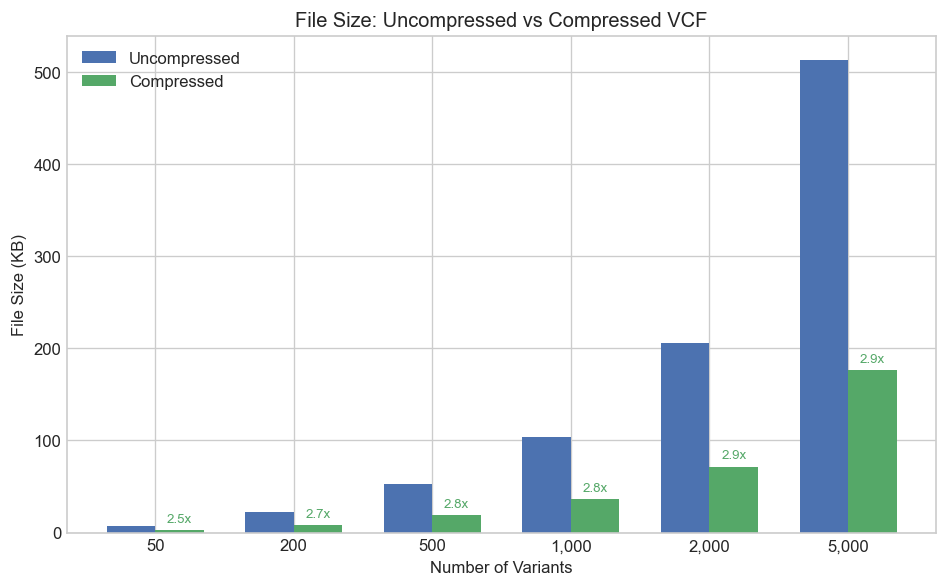

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35
uncomp = bench_df[bench_df["format"] == "Uncompressed"]
comp = bench_df[bench_df["format"] == "Compressed"]
x = np.arange(len(benchmark_sizes))

bars1 = ax.bar(x - width/2, uncomp["file_size_kb"].values, width, label="Uncompressed", color="#4C72B0")
bars2 = ax.bar(x + width/2, comp["file_size_kb"].values, width, label="Compressed", color="#55A868")

# Add compression ratio labels
for i, (u, c) in enumerate(zip(uncomp["file_size_kb"].values, comp["file_size_kb"].values)):
    ratio = u / c if c > 0 else 0
    ax.annotate(f"{ratio:.1f}x", xy=(i + width/2, c), xytext=(0, 5),
                textcoords="offset points", ha="center", fontsize=8, color="#55A868")

ax.set_xlabel("Number of Variants")
ax.set_ylabel("File Size (KB)")
ax.set_title("File Size: Uncompressed vs Compressed VCF")
ax.set_xticks(x)
ax.set_xticklabels([f"{s:,}" for s in benchmark_sizes])
ax.legend()
plt.tight_layout()
plt.savefig("test_data/compression_ratio.png", dpi=150)
plt.show()

### 6.3 — Variant Type Distribution

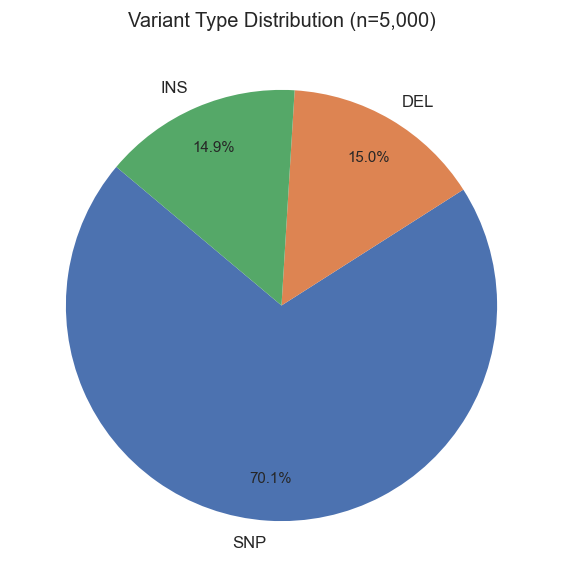

In [10]:
parser_lg = VCFParser("test_data/large.vcf")
df_lg = parser_lg.parse()
vtype_counts = parser_lg._classify_variants().value_counts()

fig, ax = plt.subplots(figsize=(6, 5))
colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]
wedges, texts, autotexts = ax.pie(
    vtype_counts.values, labels=vtype_counts.index,
    autopct="%1.1f%%", colors=colors[:len(vtype_counts)],
    startangle=140, pctdistance=0.8
)
for t in autotexts:
    t.set_fontsize(9)
ax.set_title(f"Variant Type Distribution (n={len(df_lg):,})")
plt.tight_layout()
plt.savefig("test_data/variant_types.png", dpi=150)
plt.show()

### 6.4 — Chromosome Coverage: Variants per Chromosome

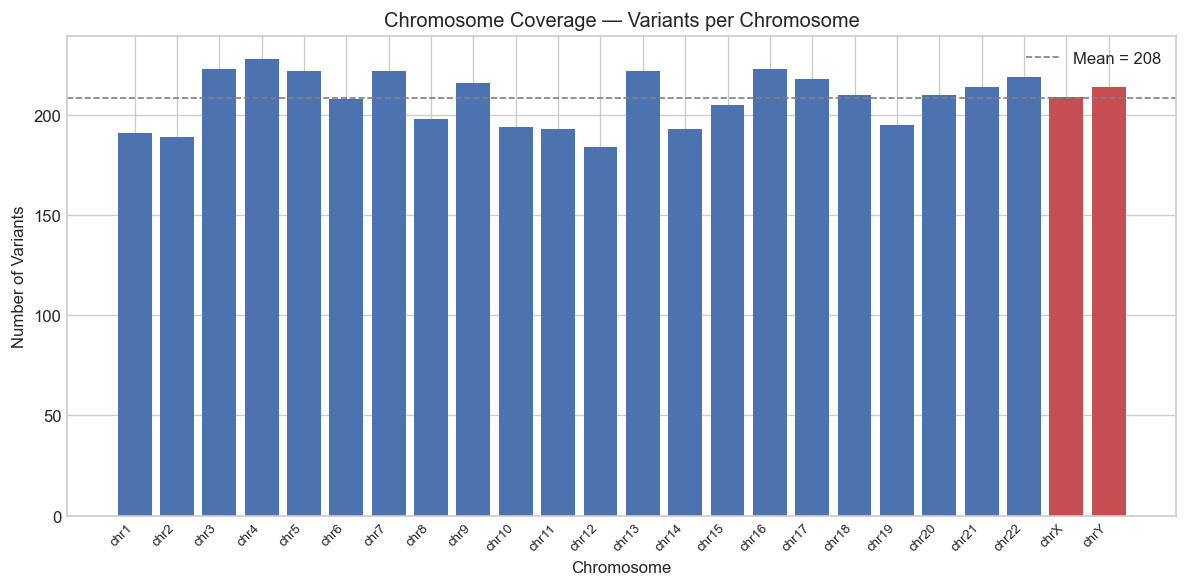

In [11]:
chrom_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
chrom_counts = df_lg["CHROM"].value_counts().reindex(chrom_order, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
bar_colors = ["#4C72B0" if c not in ("chrX", "chrY") else "#C44E52" for c in chrom_counts.index]
ax.bar(range(len(chrom_counts)), chrom_counts.values, color=bar_colors)
ax.set_xticks(range(len(chrom_counts)))
ax.set_xticklabels(chrom_counts.index, rotation=45, ha="right", fontsize=8)
ax.set_xlabel("Chromosome")
ax.set_ylabel("Number of Variants")
ax.set_title("Chromosome Coverage — Variants per Chromosome")

mean_val = chrom_counts.mean()
ax.axhline(y=mean_val, color="gray", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.0f}")
ax.legend()
plt.tight_layout()
plt.savefig("test_data/chromosome_coverage.png", dpi=150)
plt.show()

### 6.5 — Quality Score Distribution & FILTER Status

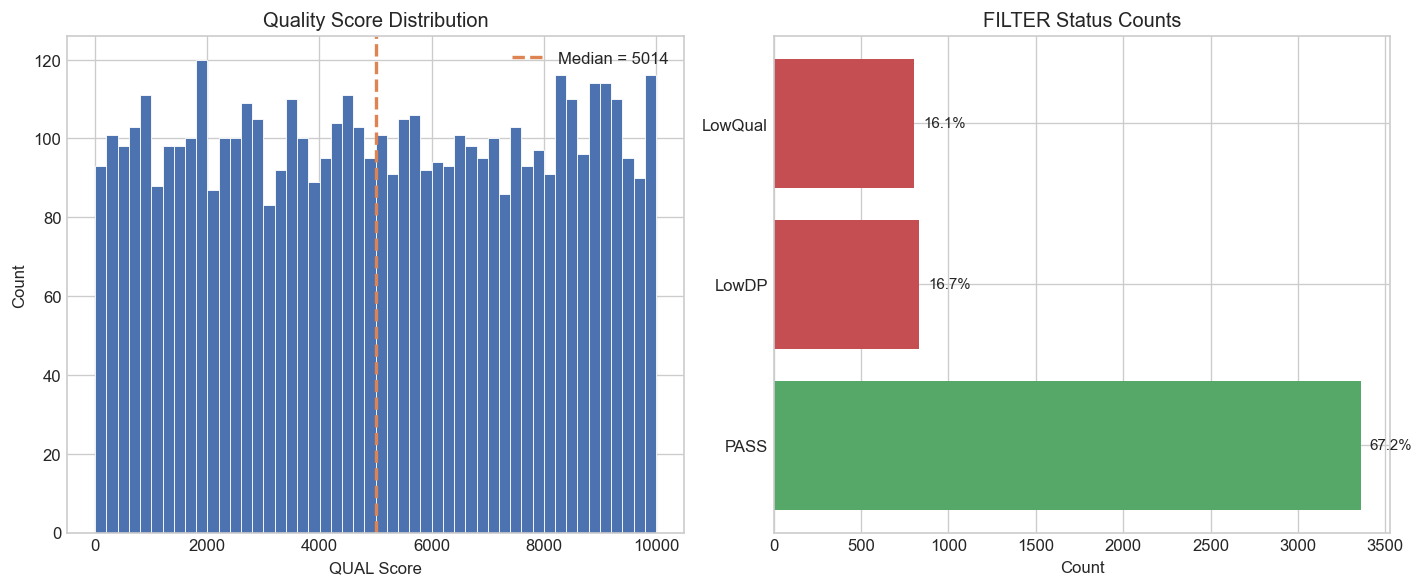

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: quality score histogram
ax1 = axes[0]
qual_vals = df_lg["QUAL"].dropna()
ax1.hist(qual_vals, bins=50, color="#4C72B0", edgecolor="white", linewidth=0.5)
ax1.axvline(qual_vals.median(), color="#DD8452", linestyle="--", linewidth=2,
            label=f"Median = {qual_vals.median():.0f}")
ax1.set_xlabel("QUAL Score")
ax1.set_ylabel("Count")
ax1.set_title("Quality Score Distribution")
ax1.legend()

# Right: filter status counts
ax2 = axes[1]
filter_counts = df_lg["FILTER"].value_counts()
colors_filter = ["#55A868" if f == "PASS" else "#C44E52" for f in filter_counts.index]
ax2.barh(filter_counts.index.astype(str), filter_counts.values, color=colors_filter)
ax2.set_xlabel("Count")
ax2.set_title("FILTER Status Counts")

# Add percentage labels
total = filter_counts.sum()
for i, (val, name) in enumerate(zip(filter_counts.values, filter_counts.index)):
    ax2.text(val + total * 0.01, i, f"{val/total*100:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("test_data/quality_and_filters.png", dpi=150)
plt.show()

## 7. Test Coverage Summary

In [13]:
# Summarize what the test suite covers
coverage_areas = {
    "Uncompressed parsing":   True,
    "Compressed (.gz) parsing": True,
    "Compressed == Uncompressed output": True,
    "Column types (POS, QUAL)": True,
    "Categorical CHROM/FILTER": True,
    "Header: file format":    True,
    "Header: INFO fields":    True,
    "Header: FILTER fields":  True,
    "Header: contig fields":  True,
    "Header: sample IDs":     True,
    "Empty VCF file":         True,
    "Summary statistics":     True,
    "Parse time tracking":    True,
}

total = len(coverage_areas)
covered = sum(coverage_areas.values())
print(f"Test coverage areas: {covered}/{total} ({covered/total*100:.0f}%)")
print()
for area, status in coverage_areas.items():
    mark = "PASS" if status else "MISS"
    print(f"  [{mark}] {area}")

Test coverage areas: 13/13 (100%)

  [PASS] Uncompressed parsing
  [PASS] Compressed (.gz) parsing
  [PASS] Compressed == Uncompressed output
  [PASS] Column types (POS, QUAL)
  [PASS] Categorical CHROM/FILTER
  [PASS] Header: file format
  [PASS] Header: INFO fields
  [PASS] Header: FILTER fields
  [PASS] Header: contig fields
  [PASS] Header: sample IDs
  [PASS] Empty VCF file
  [PASS] Summary statistics
  [PASS] Parse time tracking
